In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex')

In [4]:
import scipy.integrate as si
import scipy.interpolate as sp
import scipy.optimize as so

# V5

## basic fun

In [5]:
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
def sinh_redued(x):
    if x==0: 
        return 1
    else: 
        return np.sinh(x)/x
    


ddp_string="(-8*dp*mtr**2*p*Pi**2 - (mtr**4*mtR*p + 4*(dp**2*mtR**2 + \
mtr**3*(mtr - m_nu)*m_phi_x**2)*Pi**2)*r + \
mtr**6*r*ArcTanh(p/mtR))/(4.*mtr**2*p*Pi**2*r)"
ddp0_string="(mtr*(4*m_nu*m_phi_x**2*Pi**2 - mtr*(mtR*p + 4*m_phi_x**2*Pi**2) + \
mtr**3*ArcTanh(p/mtR)))/(4.*p*Pi**2)"
nt_string="(mtr*mtR*p - mtr**3*ArcTanh(p/mtR))/(4.*Pi**2)"

delta_m_string="(nt*r**2*sinh_redued(m_phi_x*r))/(Exp(m_phi_x*R)*R)"

_debug=False
def ode_fun(t,y,para):
#     y=[dp,p]   
    dp=y[0];p=y[1];r=t;
    m_phi_x=para["m_phi_x"]
    mtR=para["mtR"] #mtR mean m-tilde-R, or $\tilde{m}_R$
    m_nu=para["m_nu"]
    
    if p <=para["p_cut"]:
        return [0,0]
    if mtR<= p:
        if _debug: print ("warning:mtR<= p; (mtR, p)=",(mtR, p) )
        return [0,0]    
#     if mtR**2 - p**2<0: print(mtR, p)        
    mtr=Sqrt(mtR**2 - p**2)
        
    if r==0:
        ddp=eval(ddp0_string)
    else:
        ddp=eval(ddp_string)
    dy=[ddp,dp]
    return dy


def solve(p_F0=0.3,m_phi_x=0.0,mtR=0.9637,m_nu=1,r_max=100,t_eval=None):
    p_cut=p_F0*1e-4
    para={"m_phi_x":m_phi_x,"mtR":mtR,"m_nu":m_nu,"p_cut":p_cut}
    sol=si.solve_ivp(lambda t,y: ode_fun(t,y,para),
                     t_span=[0,r_max],y0=[0,p_F0],
                     dense_output=True,t_eval=t_eval)
    R=0    
    i=np.argmax(sol.y[1]<=p_cut) 
    if i>0: R=sol.t[i]
#     for i,p in enumerate(sol.y[1]):
#         if p<=p_cut:
#             R=sol.t[i]
#             break

#     def p_fun(r):
#         return 
    p_fun=sp.interp1d(sol.t,sol.y[1],kind='cubic')
    def n_fun(r):
        if r>R: raise ValueError
        p=p_fun(r)
        return p**3/(6*Pi**2)
    def nt_fun(r): #nt mean n-tilde, i.e. $\tilde{n}$
        p=p_fun(r)
        if mtR< p: print(mtR, p,r,R);raise ValueError   
        mtr=Sqrt(mtR**2 - p**2)
        return eval(nt_string)
    def integrand(r):
        return nt_fun(r)*r**2*sinh_redued(m_phi_x*r)

    if R>0:
        m_nu_inf=mtR+ Exp(-m_phi_x*R)/R*si.quad(integrand,a=0,b=R, epsrel=1e-4)[0] 
        N=si.quad(lambda r:n_fun(r) * 4*Pi*r**2, a=0,b=R, epsrel=1e-4)[0]
    else:
        m_nu_inf, N=None, None
    result={"r":sol.t,"p_F":sol.y[1],"p_fun":p_fun,"R":R,"N":N,"m_nu_inf":m_nu_inf,
            "p_F0":p_F0,"m_phi_x":m_phi_x}
    return result

def root_concave(fun,bracket,rtol=1e-5,check_sol=False):
    def newfun(x):
#         print ("x =", x)
        if x > bracket[1]:
#             print ("x too large:", x)
            return fun(bracket[1])+(x-bracket[1])
        if x < bracket[0]:
#             print ("x too small:", x)
            return fun(bracket[0])+(bracket[0]-x)
            
        y=fun(x)
        if y>=0:
            return y
        else:
            raise Exception('f<0 already found', x)
    try:      
        mini=so.minimize_scalar(newfun,bracket=bracket)#,options={"maxiter":10})
        if mini.fun>0: return None
        xmin=mini.x
    except Exception as inst:
#         print (inst.args)
        xmin=inst.args[1]
#     global sol1, sol2
    sol1=so.root_scalar(fun,bracket=[bracket[0],xmin],rtol=rtol)
    sol2=so.root_scalar(fun,bracket=[xmin,bracket[1]],rtol=rtol)
    if check_sol:
        return [{"x":sol1.root,"f":fun(sol1.root)},{"x":sol2.root,"f":fun(sol2.root)}]
    else:
        return sol1.root,sol2.root


In [6]:
def fun(x):
    if x<1:
        return 1e3
    else:
        return x-2
    
temp=root_concave(fun,[0.1,10],check_sol=True)
temp[0:2]
# sol1, sol2
# fun(sol1.root)

[{'x': 1.0000021461790778, 'f': -0.9999978538209222}, {'x': 2.0, 'f': 0.0}]

## study a special case

In [7]:
global result_debug
def auto_tune3(p_F0=0.3,m_phi_x=0.0,bracket=[1.0001,4],m_nu=1,r_max=100,t_eval_step=300):
    def auto_tune_goal(ratio):
        result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                     t_eval=np.linspace(0,r_max,t_eval_step))
        if result["m_nu_inf"]==None: 
            return 1e3
        return result["m_nu_inf"]-1   
    double_root=root_concave(auto_tune_goal,bracket=bracket,check_sol=True)
    result2=[]
    if double_root==None: return None
    for sol in double_root:
        if -1e-3<sol["f"]<1e-2:
            ratio=sol["x"]
            result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                             t_eval=np.linspace(0,r_max,t_eval_step))
            result["ratio"]=ratio
        else:
            result={"p_F0":p_F0,"R":0,"N":0,"ratio":0,"m_nu_inf":0}
        result2.append(result)
    return {"down":result2[0],"up":result2[1]}

def tune_test(p_F0=0.3,m_phi_x=0.0,ratio_list=[2.15],m_nu=1,r_max=100,t_eval_step=300):
    def auto_tune_goal(ratio):
        result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                     t_eval=np.linspace(0,r_max,t_eval_step))
        if result["m_nu_inf"]==None: 
            return 1e20
        return result["m_nu_inf"]-1 
    return [auto_tune_goal(ratio) for ratio in ratio_list]

In [8]:
# np.interp(m_phi_x,[0.0,0.02,0.05,0.1,0.115],[0.01,0.025,0.155,0.615,0.8])

In [9]:
# p_F0_list[5]

sol found at 0.01
0.0928808494568543 99.99607392315045 bracket= [1.000001, 120.0] 199.07981596319266
sol found at 0.003
0.01527227785096386 333.33215753347645 bracket= [1.000001, 400.0] 363.91278255651133
sol found at 0.002
0.008321967275373517 499.99921703282683 bracket= [1.000001, 600.0] 447.2894578915783
sol found at 0.001
0.002950807261222603 999.9996082301567 bracket= [1.000001, 1200.0] 634.2068413682737
sol found at 0.0008
0.002114392798291669 1249.999708144614 bracket= [1.000001, 1499.9999999999998] 710.2220444088819


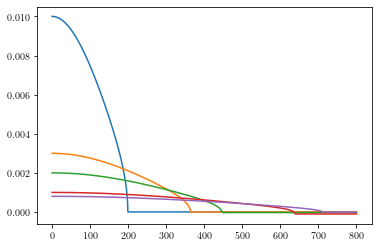

In [10]:
m_phi_x =0.0

for p_F0 in [0.01,3e-3,2e-3,1e-3,0.8e-3]:
    r_max=800 #350*0.03/p_F0
# for i,p_F0 in enumerate(p_F0_list):    
#     r_max=rmax_fun()
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    if result != None:
        print("sol found at", p_F0)
        print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
        plt.plot(result["up"]["r"],result["up"]["p_F"])

sol found at 0.6379
194.63650271850275 1.1622615808930472 bracket= [1.000001, 1.8811725975858284] 34.62049989555835
198.33255831724045 1.1581502097337915 bracket= [1.000001, 1.8811725975858284] 34.77729563783897


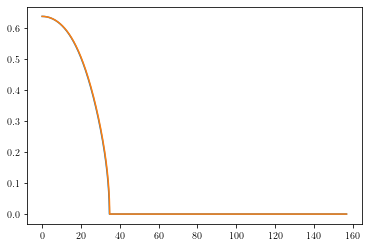

In [131]:
# m_phi_x =0.0
# for p_F0 in [0.5863]:
# m_phi_x =0.02
# for p_F0 in [0.6804]:
m_phi_x =0.01
for p_F0 in [0.6379]:
# m_phi_x =0.115
# for p_F0 in [0.83]:
    r_max=rmax_fun()
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    if result != None:
        print("sol found at", p_F0)
        print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
        plt.plot(result["up"]["r"],result["up"]["p_F"])
        print(result["down"]["N"],result["down"]["ratio"],"bracket=",bracket,result["down"]["R"])
        plt.plot(result["down"]["r"],result["down"]["p_F"])

m_phi_x =0.118

for p_F0 =

[0.832,0.833,0.835,0.836,0.8362,0.8364,0.8366,0.8368,0.8370,0.8372] works but 0.8372 looks suspicious

0.834 doesn't work

[0.825,0.826,0.827,0.828,0.829,0.83,0.831] # all double values with a fake one

0.824,0.823,0.822,0.821 doesn't work

0.8368
11149.49160334669 1.1896342113879181 bracket= [1.000001, 1.4340344168260037] 106.34126825365072
15597.262000926137 1.188103680296845 bracket= [1.000001, 1.4340344168260037] 112.40248049609922
0.837
12338.210289158942 1.1888819204735948 bracket= [1.000001, 1.4336917562724014] 107.99159831966394
12915.120145833906 1.1886585309418318 bracket= [1.000001, 1.4336917562724014] 108.74174834966993
0.8372
13588.361362186684 1.1882229153995598 bracket= [1.000001, 1.4333492594362158] 108.98179635927185
13662.094521971663 1.1882016131694444 bracket= [1.000001, 1.4333492594362158] 110.03200640128026


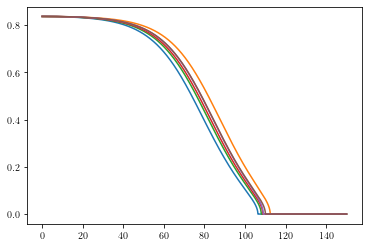

In [379]:
m_phi_x =0.118
for p_F0 in [0.8368,0.8370,0.8372]:
    print(p_F0)
    r_max=150
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
    plt.plot(result["up"]["r"],result["up"]["p_F"])
    if result["down"]['ratio'] >0:
        print(result["down"]["N"],result["down"]["ratio"],"bracket=",bracket,result["down"]["R"])
        plt.plot(result["down"]["r"],result["down"]["p_F"])
# plt.xlim(90,110)

0.797
2096.7943287532744 1.2545226304789203 bracket= [1.000001, 1.5056461731493098] 108.44168833766753
2096.7943287532744 1.2545226304789203 bracket= [1.000001, 1.5056461731493098] 108.44168833766753
0.802
2218.8635415937947 1.246113654409073 bracket= [1.000001, 1.4962593516209475] 95.56911382276455
2218.8635415937947 1.246113654409073 bracket= [1.000001, 1.4962593516209475] 95.56911382276455
0.807
2378.624731819641 1.237571691843592 bracket= [1.000001, 1.486988847583643] 88.9377875575115
2381.6304215991486 1.2375532752300655 bracket= [1.000001, 1.486988847583643] 93.40868173634726
0.812
2559.457625723579 1.2291800767689645 bracket= [1.000001, 1.4778325123152707] 86.68733746749349
2565.126755085209 1.2291441998123234 bracket= [1.000001, 1.4778325123152707] 91.39827965593119
0.817
2782.4655805642496 1.2208234656471015 bracket= [1.000001, 1.4687882496940026] 85.15703140628125
0.822
2890.775306055923 1.2148757995178547 bracket= [1.000001, 1.4598540145985401] 95.05901180236047
2890.7753060

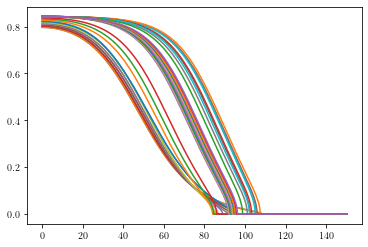

In [341]:
m_phi_x =0.115
# for p_F0 in [0.797]:
for p_F0 in [0.797     , 0.802, 0.807, 0.812, 0.817, 0.822, 0.827, 0.8325, 0.837, 
             0.8427    , 0.8428, 0.8429, 0.8430, 0.8431,
       0.8432, 0.8433, 0.8434, 0.8435,0.8436, 0.8437]:
    print(p_F0)
    r_max=150
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
    plt.plot(result["up"]["r"],result["up"]["p_F"])
    if result["down"]['ratio'] >0:
        print(result["down"]["N"],result["down"]["ratio"],"bracket=",bracket,result["down"]["R"])
        plt.plot(result["down"]["r"],result["down"]["p_F"])
# plt.xlim(90,110)

[0.797     , 0.802, 0.807, 0.812, 0.817, 0.822, 0.827, 0.8325, 0.837, 
             0.8427    , 0.8428, 0.8429, 0.8430, 0.8431,
       0.8432, 0.8433, 0.84335,0.8434,0.84345,0.84355,0.8436, 0.8437]

0.84335
8944.092066461333 1.1739836168254132 bracket= [1.000001, 1.4228967806960335] 93.97879575915184
14057.563408726883 1.1715793103605703 bracket= [1.000001, 1.4228967806960335] 102.83056611322264
0.8434
9060.791788280647 1.173841427255352 bracket= [1.000001, 1.422812425895186] 94.18883776755351
13581.044310912812 1.171664317592299 bracket= [1.000001, 1.422812425895186] 102.2004400880176
0.84345
9203.245275160018 1.1736826852662277 bracket= [1.000001, 1.4227280810955005] 94.45889177835566
12032.50362729725 1.1721208979202344 bracket= [1.000001, 1.4227280810955005] 99.40988197639528
0.84355
9343.534951769434 1.173480075225745 bracket= [1.000001, 1.422559421492502] 94.72894578915783
11770.218419737948 1.172129309730108 bracket= [1.000001, 1.422559421492502] 98.95979195839168
0.8436
9515.33134952094 1.1733085551409086 bracket= [1.000001, 1.422475106685633] 95.05901180236047
11749.966131629895 1.1720884050741993 bracket= [1.000001, 1.422475106685633] 98.77975595119024
0.8437
9869.800215

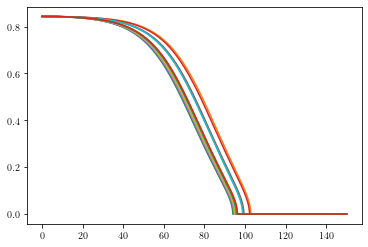

In [368]:
m_phi_x =0.115
for p_F0 in [0.8437,0.84371]:
    print(p_F0)
    r_max=150
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
    plt.plot(result["up"]["r"],result["up"]["p_F"])
    if result["down"]['ratio'] >0:
        print(result["down"]["N"],result["down"]["ratio"],"bracket=",bracket,result["down"]["R"])
        plt.plot(result["down"]["r"],result["down"]["p_F"])

In [200]:
m_phi_x =0.115
p_F0=0.843
for ratio in [1.16,1.17,1.171,1.173,1.175,1.18,1.19,1.20]:
    r_max=150
    result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,m_nu=1,
          r_max=r_max,t_eval=np.linspace(0,r_max,5000))
    print(result["m_nu_inf"])


None
1.0230802391359277
1.003446706365525
0.9957701729080853
1.0001373506500042
1.0119293300529355
1.028721800366398
1.0422911444789553


[0.615     , 0.620, 0.626, 0.631, 0.638,
       0.643, 0.648, 0.654, 0.659, 0.665,0.709, 0.753, 0.796, 0.84, 0.842,
       0.844, 0.847, 0.848, 0.851, 0.853,
       0.856, 0.858, 0.86 ]
0.615, 0.620, 0.626, 0.631, 0.638,
0.643, 0.648, 0.654, 0.659, 0.665,0.709, 0.753, 0.796, 0.84, 0.842,
0.844, 0.847, 0.848,
0.851,0.853,0.855,0.8553,0.8562,0.8564,0.8566,0.8568
0.8568,0.85704,0.85706,0.85708,0.85710,0.85712

0.851
2650.2030920486145 1.1332374221442583 bracket= [1.000001, 1.4101057579318448] 61.6623324664933
16986.888248000752 1.1142998185563744 bracket= [1.000001, 1.4101057579318448] 95.26905381076214
0.853
2994.083385585558 1.1288229274912311 bracket= [1.000001, 1.4067995310668229] 63.132626525305064
13004.846957810343 1.1135472720705475 bracket= [1.000001, 1.4067995310668229] 88.84776955391078
0.855
3434.3528187896604 1.1245098371414812 bracket= [1.000001, 1.4035087719298245] 64.8129625925185
10360.338611470344 1.1129833413973977 bracket= [1.000001, 1.4035087719298245] 83.74674934986997
0.8553
3642.9840077308236 1.1232206264070366 bracket= [1.000001, 1.403016485443704] 65.74314862972595
10339.812119915625 1.1127816259840098 bracket= [1.000001, 1.403016485443704] 83.56671334266854
0.8562
4090.833095399008 1.1206354062367092 bracket= [1.000001, 1.401541695865452] 67.39347869573915
8903.651652095301 1.112904284671442 bracket= [1.000001, 1.401541695865452] 80.80616123224645
0.8564
4300.92899

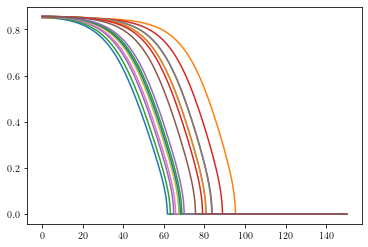

In [416]:
m_phi_x =0.1
# for p_F0 in [0.8568,0.857,0.85702,0.85704,0.85706,0.85708,0.85710,0.85712,0.85714,0.8575,0.858]:
for p_F0 in [0.851,0.853,0.855,0.8553,0.8562,0.8564,0.8566,0.8568]:
    print(p_F0)
    r_max=150
    bracket=[1+1e-6,1.2/p_F0]
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=bracket,
                          r_max=r_max,t_eval_step=5000)
    print(result["up"]["N"],result["up"]["ratio"],"bracket=",bracket,result["up"]["R"])
    plt.plot(result["up"]["r"],result["up"]["p_F"])
    if result["down"]['ratio'] >0:
        print(result["down"]["N"],result["down"]["ratio"],"bracket=",bracket,result["down"]["R"])
        plt.plot(result["down"]["r"],result["down"]["p_F"])

sol found at 0.03
1.5047462048883187 33.332825911098546 bracket= [1.00001, 40.0] 227.08541708341667
sol found at 0.025
1.5548985576073688 39.99996807245898 bracket= [1.00001, 47.99999999999999] 370.63412682536506
sol found at 0.0248
1.566398143590746 40.32256432593706 bracket= [1.00001, 48.38709677419355] 403.5207041408282


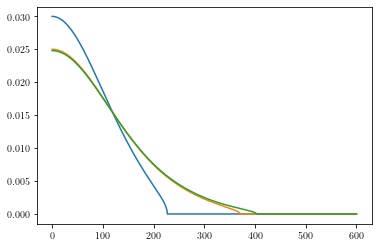

In [73]:
m_phi_x =0.02
for p_F0 in [0.03,0.025,0.0248,0.0247]:
    r_max=600 #350*0.03/p_F0
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=[1+1e-5,1.2/p_F0],
                          r_max=r_max,t_eval_step=5000)
    if result != None:
        print("sol found at", p_F0)
        print(result["up"]["N"],result["up"]["ratio"],"bracket=",[1+1e-5,1.2/p_F0],result["up"]["R"])
#         print(result["down"]["N"],result["down"]["ratio"],result["down"]["R"])
        plt.plot(result["up"]["r"],result["up"]["p_F"])
#         plt.plot(result["down"]["r"],result["down"]["p_F"])

sol found at 0.008
0.1893722350298388 124.99982884280325 bracket= [1.000001, 150.0] ,rmax= 800 ,R= 405.8411682336467
sol found at 0.007
0.18646362115962165 142.85707118709846 bracket= [1.000001, 171.42857142857142] ,rmax= 800 ,R= 512.7425485097019
sol found at 0.00654
0.18868424089977712 152.905169152876 bracket= [1.000001, 183.4862385321101] ,rmax= 800 ,R= 596.4392878575716
sol found at 0.00652
0.18941173927107374 153.37420452578252 bracket= [1.000001, 184.04907975460122] ,rmax= 800 ,R= 617.8835767153431


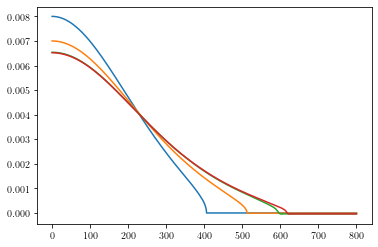

In [157]:
m_phi_x =0.01
for p_F0 in [0.008,0.007,6.58e-3,6.57e-3,6.56e-3,6.54e-3,6.52e-3]:
    r_max=rmax_fun() #350*0.03/p_F0
    result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=[1+eps_fun(),1.2/p_F0],
                          r_max=r_max,t_eval_step=5000)
    if result != None:
        print("sol found at", p_F0)
        print(result["up"]["N"],result["up"]["ratio"],"bracket=",[1+eps_fun(),1.2/p_F0],
              ",rmax=",r_max,",R=",result["up"]["R"])
        plt.plot(result["up"]["r"],result["up"]["p_F"])

None
0.9999999506700743
1.0000000162189708
1.0001694076576237


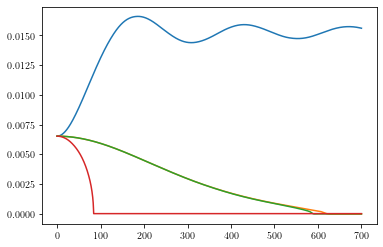

In [164]:
p_F0=6.52e-3
m_phi_x =0.01
for i, ratio in enumerate([153.3,153.37420452578252,153.374206,153.4]):
    r_max=700
    t_eval_step=5000
    sol=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                         t_eval=np.linspace(0,r_max,t_eval_step))
    print(sol["m_nu_inf"])
    plt.plot(sol["r"],sol["p_F"])

None
0.999999913525797
1.0000001834167231


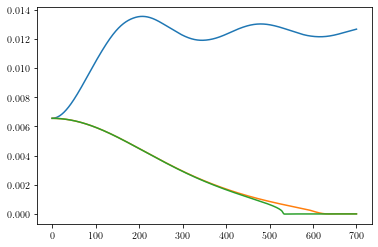

In [80]:
p_F0=6.56e-3
m_phi_x =0.01
for i, ratio in enumerate([152.4,152.43899208396374,152.439]):
    r_max=700
    t_eval_step=5000
    sol=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                         t_eval=np.linspace(0,r_max,t_eval_step))
    print(sol["m_nu_inf"])
    plt.plot(sol["r"],sol["p_F"])

## general $m_\phi$

In [13]:
global result_debug
def auto_tune3(p_F0=0.3,m_phi_x=0.0,bracket=[1.0001,4],m_nu=1,r_max=100,t_eval_step=300):
    def auto_tune_goal(ratio):
        result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                     t_eval=np.linspace(0,r_max,t_eval_step))
        if result["m_nu_inf"]==None: 
            return 1e3
        return result["m_nu_inf"]-1   
    double_root=root_concave(auto_tune_goal,bracket=bracket,check_sol=True)
    result2=[]
    if double_root==None: return None
    for sol in double_root:
        if -1e-3<sol["f"]<1e-2:
            ratio=sol["x"]
            result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                             t_eval=np.linspace(0,r_max,t_eval_step))
            result["ratio"]=ratio
        else:
            result={"p_F0":p_F0,"R":0,"N":0,"ratio":0,"m_nu_inf":0}
        result2.append(result)
    return {"down":result2[0],"up":result2[1]}

def tune_test(p_F0=0.3,m_phi_x=0.0,ratio_list=[2.15],m_nu=1,r_max=100,t_eval_step=300):
    def auto_tune_goal(ratio):
        result=solve(p_F0=p_F0,m_phi_x=m_phi_x,mtR=ratio * p_F0,r_max=r_max,
                     t_eval=np.linspace(0,r_max,t_eval_step))
        if result["m_nu_inf"]==None: 
            return 1e20
        return result["m_nu_inf"]-1 
    return [auto_tune_goal(ratio) for ratio in ratio_list]

In [14]:
def rmax_fun():
    global p_F0, m_phi_x
    if m_phi_x==0:
        if p_F0<1e-2:
            return 800
        if p_F0<5e-2:
            return 200
        else:
            return 100
    if p_F0<0.3:
        return 800
    return 100/p_F0
def eps_fun():
    return 1e-6
#     global p_F0, m_phi_x
#     return np.interp(m_phi_x,[0,0.004,0.05,0.1,0.2],[1e-5,1e-6,1e-6,1e-6,1e-6])

def p_F0_max_fun():
    global p_F0, m_phi_x
    return np.interp(m_phi_x,[0.0,    0.01,    0.02,  0.05,0.07,0.1,0.115],
                             [0.5863, 0.6379,  0.6804, 0.8,0.83,0.86,0.84])
def p_F0_min_fun():
    global m_phi_x
    return np.interp(m_phi_x,[0.0,   0.01,   0.02,     0.05,  0.1,   0.115],
                             [0.8e-3,6.52e-3,2.48e-2,  0.155, 0.615, 0.8])

def generate_p_F0_list():
    global m_phi_x
    if m_phi_x==0.115:
        return np.array([0.797, 0.802, 0.807, 0.812, 0.817, 0.821, 0.823, 0.827, 0.8325, 0.837, 
                         0.8427, 0.8428, 0.8429, 0.8430, 0.8431,
                        0.8432, 0.8433, 0.84335,0.8434,0.84345,0.84355,0.8436, 0.8437])
#         return np.concatenate([
#                             np.linspace(0.797,0.8427,10),
#                           np.linspace(0.8427,0.8437,10)
#                           ])
    if m_phi_x==0.118:
        return np.array([0.826,0.827,0.828,0.829,0.83,0.831,
                         0.832,0.833,0.835,0.836,
                         0.8362,0.8364,0.8366,0.8368,0.8370])
    if m_phi_x==0.1:
        return np.array([0.615, 0.620, 0.626, 0.631, 0.638,
                        0.643, 0.648, 0.654, 0.659, 0.665,0.709, 0.753, 0.796, 0.84, 0.842,
                        0.844, 0.847, 0.848,
                        0.851,0.853,0.855,0.8553,0.8562,0.8564,0.8566,0.8568,
                        0.8568,0.85704,0.85706,0.85708,0.85710,0.85712])
    
    a,b=p_F0_min_fun(),p_F0_max_fun()
    da,db=0.1,0.1
    n1,n2,n3=10,10,10
    if m_phi_x>0.05:
        n2=5
        da,db=0.05,0.02
        
    return np.concatenate([np.geomspace(a,a+da,n1),
                           np.linspace(a+da,b-db,n2)[1:-1],
                           np.linspace(b-db,b,n3)
                          ])


def plot_curves(xlabel="R",ylabel="N",marker=None):
    for i,result_list in enumerate(result_list_list):
        x_list,y_list=[],[]
        for up_or_down in ["up","down"]:             
            fff={"up":np.copy,"down":np.flip}[up_or_down]
            for result in fff(result_list):
                bad_point= up_or_down=="down" and (result["down"]["ratio"]>1.5 or result["up"]["m_phi_x"]>0.1)
                # bad_point means a mistake: UR solutions are absent and the solver jumps to NR                     
                

                    
                
                if (not bad_point) and -1e-3<(result[up_or_down]["m_nu_inf"]-1)<1e-2:
                    x_list.append(result[up_or_down][xlabel])
                    if ylabel == "mt0/p_F0":
                        r=result[up_or_down]["ratio"]
                        y=Sqrt(r**1-1)
                        y_list.append(y)
                    elif ylabel == "mt0":
                        r=result[up_or_down]["ratio"]
                        p_F0=result[up_or_down]["p_F0"]
                        r0=Sqrt(r**1-1)
                        y_list.append(r0* p_F0 )
                    elif ylabel == "ratio-1":
                        r=result[up_or_down]["ratio"]
                        y_list.append(r-1 )
                    else:
                        y_list.append(result[up_or_down][ylabel])
                    m_phi_x=result[up_or_down]["m_phi_x"]
        plt.plot(x_list,y_list,color="C"+str(i), 
                 label=r"$m_\phi/(y m_\nu)=$"+str(m_phi_x),marker=marker)
    plt.grid()
    plt.legend()
    
def plot_points(xlabel="R",ylabel="N",marker="+"):
    for i,result_list in enumerate(result_list_list):
        x_list,y_list=[],[]
        for up_or_down in ["up","down"]:             
            for result in result_list:
                if -1e-3<(result[up_or_down]["m_nu_inf"]-1)<1e-2:
                    x_list.append(result[up_or_down][xlabel])
                    y_list.append(result[up_or_down][ylabel])
                    m_phi_x=result[up_or_down]["m_phi_x"]
        plt.scatter(x_list,y_list,color="C"+str(i), 
                 label=r"$m_\phi/(y m_\nu)=$"+str(m_phi_x),marker=marker)
    plt.grid()
    plt.legend()

In [15]:
result_list_list=[]
# for m_phi_x in [0.01,0.02,0.05,0.1,0.115,0.118]:
for m_phi_x in [0.1]:
    p_F0_max=p_F0_max_fun()
    p_F0_list=generate_p_F0_list()
    
    result_list=[]
    for i,p_F0 in enumerate(p_F0_list):
        print ("\r",i,",",m_phi_x,end="      ") 
        r_max=rmax_fun()
        result=auto_tune3(p_F0=p_F0,m_phi_x=m_phi_x,bracket=[1+eps_fun(),1.2/p_F0],
                          r_max=r_max,t_eval_step=5000)
        if not (result ==None):
            result_list.append(result)
    result_list_list.append(result_list)

 31 , 0.1      

In [16]:
p_F0_list

array([0.615  , 0.62   , 0.626  , 0.631  , 0.638  , 0.643  , 0.648  ,
       0.654  , 0.659  , 0.665  , 0.709  , 0.753  , 0.796  , 0.84   ,
       0.842  , 0.844  , 0.847  , 0.848  , 0.851  , 0.853  , 0.855  ,
       0.8553 , 0.8562 , 0.8564 , 0.8566 , 0.8568 , 0.8568 , 0.85704,
       0.85706, 0.85708, 0.8571 , 0.85712])

In [425]:
for i,result_list in enumerate(result_list_list):
    m_phi_x=result_list[0]["up"]["m_phi_x"]
    file_path="data/N_body_solve_result"+str(m_phi_x)+".npy"
    print(file_path)
    np.save(file_path,result_list)

data/N_body_solve_result0.1.npy


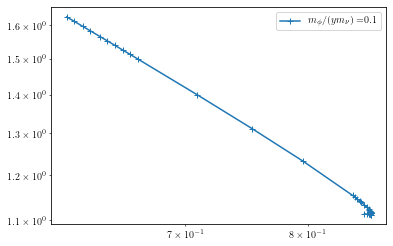

In [17]:
plot_curves("p_F0","ratio",marker="+")
plt.yscale("log")
plt.xscale("log")
plt.show()

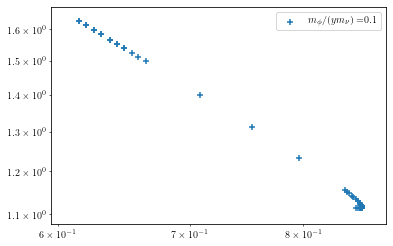

In [18]:
plot_points("p_F0","ratio",marker="+")
plt.yscale("log")
plt.xscale("log")
# plt.xlim(1e-4,1e0)
plt.show()

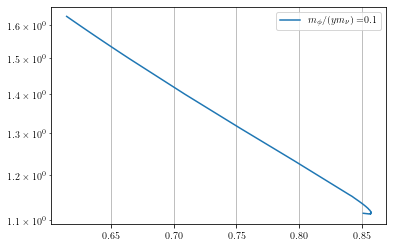

In [19]:
plot_curves("p_F0","ratio")
plt.yscale("log")
plt.show()

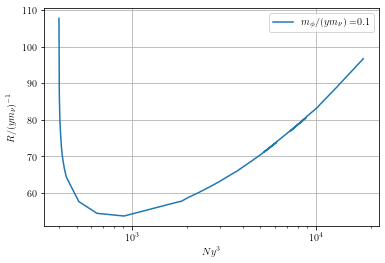

In [20]:
plot_curves("N","R")
plt.xscale("log")
plt.ylabel(r"$R/(y m_{\nu})^{-1}$")
plt.xlabel("$N y^3$")
# plt.ylim(0,700)
# plt.xlim(1e-3,1e5)
# plt.savefig(r'../fig/R-N-large_m.pdf',  bbox_inches='tight')
plt.show()


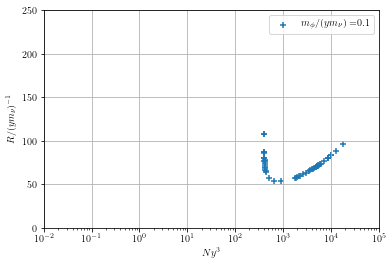

In [431]:
plot_points("N","R",marker="+")
plt.xscale("log")
plt.ylabel(r"$R/(y m_{\nu})^{-1}$")
plt.xlabel("$N y^3$")
plt.ylim(0,250)
plt.xlim(1e-2,1e5)
# plt.savefig(r'../fig/R-N-large_m.pdf',  bbox_inches='tight')
# plt.savefig(r'../fig/R-N.pdf',  bbox_inches='tight')
plt.show()

## Combine and make plots

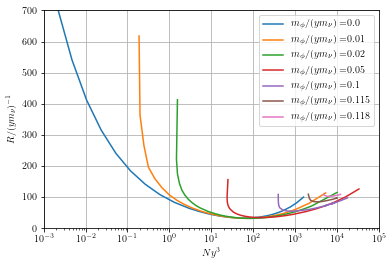

In [23]:
result_list_list=[np.load("data/N_body_solve_result"+str(m_phi_x)+".npy",allow_pickle=True)
                    for m_phi_x in [0.0,0.01,0.02,0.05,0.1,0.115,0.118] ]
plot_curves("N","R")
plt.xscale("log")
plt.ylabel(r"$R/(y m_{\nu})^{-1}$")
plt.xlabel("$N y^3$")
plt.ylim(0,700)
plt.xlim(1e-3,1e5)
# plt.savefig(r'../fig/R-N-large_m-full.pdf',  bbox_inches='tight')
plt.show()


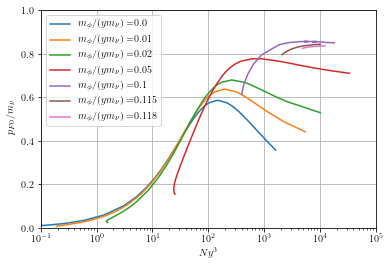

In [24]:
result_list_list=[np.load("data/N_body_solve_result"+str(m_phi_x)+".npy",allow_pickle=True)
                    for m_phi_x in  [0.0,0.01,0.02,0.05,0.1,0.115,0.118]  ]
plot_curves("N","p_F0")
plt.xscale("log")
plt.xlabel("$N y^3$")
plt.ylabel(r"$p_{F0}/{m_\nu}$")
plt.xlim(1e-1,1e5)
plt.ylim(0,1.0)
# plt.savefig(r'../fig/p_F0-N-large_m.pdf',  bbox_inches='tight')
plt.show()

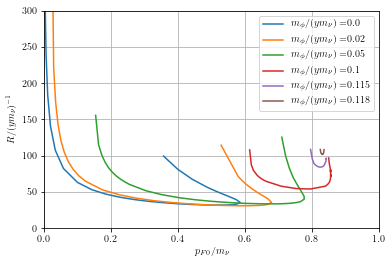

In [25]:
result_list_list=[np.load("data/N_body_solve_result"+str(m_phi_x)+".npy",allow_pickle=True)
                    for m_phi_x in [0.0,0.02,0.05,0.1,0.115,0.118] ]
plot_curves("p_F0","R")
# plt.xscale("log")
plt.ylabel(r"$R/(ym_{\nu})^{-1}$")
plt.xlabel(r"$p_{F0}/{m_\nu}$")
plt.xlim(0,1)
plt.ylim(0,300)
# plt.savefig(r'../fig/R-P_F0-all.pdf',  bbox_inches='tight')
plt.show()

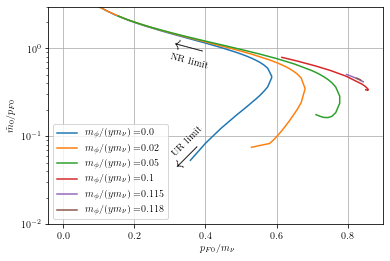

In [26]:
plot_curves("p_F0","mt0/p_F0")
plt.yscale("log")

plt.text(s="NR limit", x=0.3,y=0.6,rotation=-15)
plt.text(s=r"$\longrightarrow$", x=0.3,y=0.8,rotation=165,fontsize=20)
plt.text(s="UR limit", x=0.3,y=6e-2,rotation=45)
plt.text(s=r"$\longrightarrow$", x=0.3,y=4e-2,rotation=-135,fontsize=20)
plt.ylabel(r"$\tilde{m}_0/p_{F0}$")
plt.xlabel(r"$p_{F0}/{m_\nu}$")
plt.ylim(1e-2,3)
plt.legend()
# plt.savefig(r'../fig/mt0-pF0.pdf',  bbox_inches='tight')

plt.show()